In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage, Compose, Lambda, Resize, InterpolationMode
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusion_model import UNet
import helpers
from train import extract

2025-10-05 06:07:11.473671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759644431.487187  124980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759644431.491234  124980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 06:07:11.503904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_diffusion_variables(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    return betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance

@torch.no_grad()
def p_sample(model, x, t, t_index, low_res_img, diffusion_vars):
    """Performs a single step of denoising."""
    betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance = diffusion_vars
    
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, low_res_img) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop_and_visualize(model, shape, low_res_img, config: dict, display_every_n_steps):
    device = next(model.parameters()).device
    b = shape[0]
    img = torch.randn(shape, device=device)
    
    timesteps = config['model']['timesteps']
    diffusion_vars = get_diffusion_variables(timesteps)
    diffusion_vars = [var.to(device) for var in diffusion_vars]
    
    print(f"\n--- Generating image (displaying every {display_every_n_steps} steps) ---")

    for i in tqdm(reversed(range(0, timesteps)), desc='Sampling loop', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, low_res_img, diffusion_vars)
        
        # Display logic for Jupyter Notebook
        if i % display_every_n_steps == 0 or i == 1:
            img_to_show = (img.clamp(-1, 1) + 1) / 2
            pil_img = ToPILImage()(img_to_show.squeeze(0).cpu())
            
            plt.figure(figsize=(4, 4))
            plt.imshow(pil_img)
            plt.title(f"Denoising Step: {timesteps - i}/{timesteps}")
            plt.axis('off')
            plt.show()
            
    return img

In [3]:
# --- Main Inference Pipeline ---
def upscale_pipeline(input_img: Image, config: dict, img_size: int, device: str) -> Image:
    # Upscale with bicubic for conditioning and comparison
    conditioning_input_image = input_img.resize((img_size, img_size), Image.BICUBIC)

    # Normalize to match the training range [-1, 1]
    transform = Compose([
        ToTensor(), # Scales to [0, 1]
        Lambda(lambda t: (t * 2) - 1) # Scale to [-1, 1]
    ])
    input_tensor = transform(conditioning_input_image).unsqueeze(0).to(device)

    # Run the diffusion sampling process
    print("Starting diffusion sampling...")
    output_tensor = p_sample_loop_and_visualize(
        model, 
        shape=(1, 3, img_size, img_size), 
        low_res_img=input_tensor,
        config=config,
        display_every_n_steps=200
    )

    # De-normalize from [-1, 1] back to [0, 1]
    output_tensor = (output_tensor.clamp(-1, 1) + 1) / 2
    to_pil = ToPILImage()
    return to_pil(output_tensor.squeeze(0).cpu())

Starting diffusion sampling...

--- Generating image (displaying every 200 steps) ---


Sampling loop:  19%|█▉        | 194/1000 [00:01<00:04, 165.84it/s]

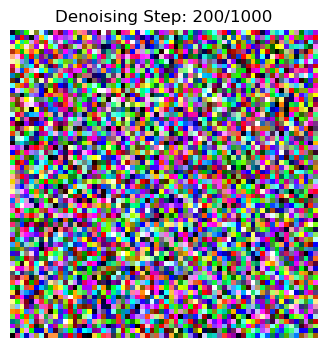

Sampling loop:  40%|███▉      | 398/1000 [00:02<00:03, 166.32it/s]

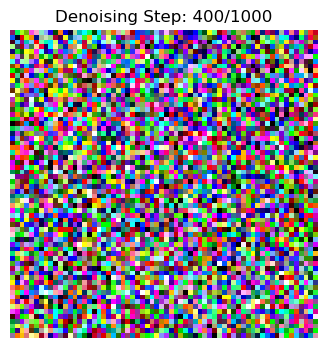

Sampling loop:  58%|█████▊    | 585/1000 [00:03<00:02, 166.24it/s]

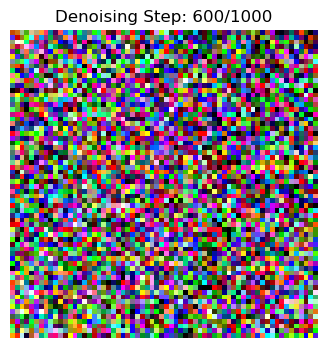

Sampling loop:  79%|███████▉  | 794/1000 [00:04<00:01, 166.53it/s]

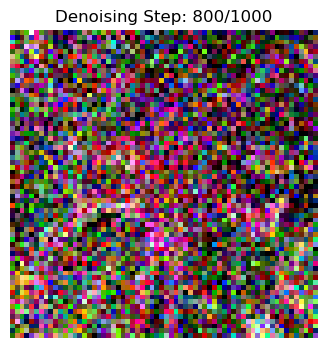

Sampling loop: 100%|█████████▉| 998/1000 [00:06<00:00, 166.37it/s]

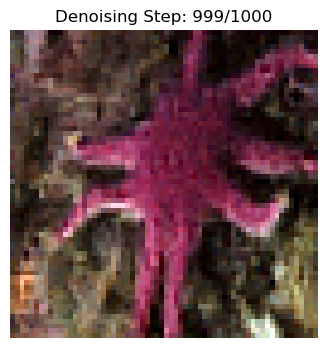

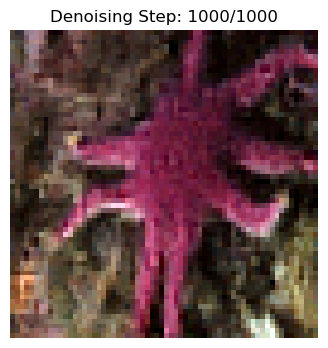

Sampling loop: 100%|██████████| 1000/1000 [00:06<00:00, 157.83it/s]


In [4]:
# The image we have is a high resolution image
# For inference, the input image is the low-resolution one
# So we resize it to the expected low-res size.

# Load config
config = helpers.load_config("./config.yaml")
device = helpers.get_device_auto()
img_size = config['data']['img_size']
upscale_factor = config['data']['upscale_factor']
lr_w = img_size // upscale_factor
lr_h = img_size // upscale_factor

# Load model
model = UNet(
    in_channels=config['model']['in_channels'],
    out_channels=config['model']['out_channels'],
).to(device)
helpers.load_model(model, config['inference']['model_path'], device)
    
high_res_img = helpers.load_img_file(config['data']['test_image'])
lr_w = lr_h = img_size // upscale_factor
low_res_input_img = high_res_img.resize((lr_w, lr_h), Image.BICUBIC)

output_img = upscale_pipeline(low_res_input_img, config, img_size, device)

In [5]:
print(f"Config:\n{config}\n")
print(f"Model:\n{model}")

Config:
{'data': {'train_dir': 'data/train', 'test_image': 'data/test/test_image.png', 'img_size': 64, 'upscale_factor': 2}, 'model': {'timesteps': 1000, 'in_channels': 6, 'out_channels': 3, 'channel_multipliers': [1, 2, 4]}, 'training': {'epochs': 100, 'batch_size': 16, 'learning_rate': 0.0002, 'save_image_every': 5, 'save_model_every': 10}, 'output': {'model_path': 'models/diffusion_upscaler.pth', 'output_dir': 'output', 'log_dir': '/home/jovyan/logs/fit/diffusion_super_res'}, 'inference': {'model_path': 'models/diffusion_upscaler_20251005_060321.pth'}}

Model:
UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (tran

Input image:
(32, 32)


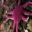

In [6]:
print("Input image:")
print(low_res_input_img.size)
low_res_input_img

Unet upscaled output:
(64, 64)


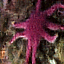

In [7]:
print("Unet upscaled output:")
print(output_img.size)
output_img

Original image downscaled:
(64, 64)


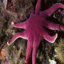

In [8]:
print("Original image downscaled:")
downscaled_input_img = high_res_img.resize((img_size, img_size), Image.BICUBIC)
print(downscaled_input_img.size)
downscaled_input_img